In [1]:
#install pint if needed
try:
    from pint import UnitRegistry
except ImportError:
    %pip install pint
    
# import units
from pint import UnitRegistry
units = UnitRegistry()

In [2]:
# download modsim.py if necessary

from os.path import basename, exists

def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve
        local, _ = urlretrieve(url, filename)
        print('Downloaded ' + local)
    
download('https://github.com/AllenDowney/ModSimPy/raw/master/' +
         'modsim.py')

In [3]:
# import functions from modsim

from modsim import *

import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import solve_ivp
import pandas as pd

For this example we will be using a AJ-60A booster from the Atlas V.

Assumptions:
- drag coefficient is the same as a baseball
- earth is a perfect circle 12,756 km in diameter (~equatorial diameter)
- thrust is constant

TODO:
- throttle trust
- improve gnc to get to orbit
    - multiple burns??
    - figure out what the burn should be to get to orbit
    - fudge burn time to get there
- multiple stages
    - unify trust/burn time/mass into a class
    - control with gnc


Pitch over happens at 244m, for this simulation we'll say the angle change instantaneously from 90 degrees (vertical) to 45 degrees. In the future a more complicated approach will be used. [This article](https://globaljournals.org/GJSFR_Volume12/6-Computational-Algorithm-for-Gravity.pdf) explains more of the math behind pitch over.

In [4]:
# Set up params, all metric
params = Params(
    x = 0,
    starting_speed = 0,

    g0 = 9.8,        # m/s**2
    Re = 6371000,

    t_end = 5000000,     # s

    C_d = 1.82, # of a baseball

    earth_diameter = 12756000, # meters

    #booster AJ-60A from an Atlas V
    max_thrust = 1688400.0, #N
    specific_impulse = 279.3, #s; need to figure out how to use this
    diameter = 	1.6,
    mass = 	46697.0,
    propellent_mass = 42630.0,
    burn_time = 94.0, # this is the correct burn time
)

In [5]:
from gravity import calc_gravity
print(calc_gravity(Vector(0,0), params))
print(calc_gravity(Vector(100000, 0), params))

x    0.0
y    0.0
Name: component, dtype: float64
x   -45991.268563
y       -0.000000
Name: component, dtype: float64


In [6]:
from gnc import get_gnc

In [7]:
from numpy import pi, deg2rad
from turnover import calc_angle

def make_system(params):
    y = params.earth_diameter / 2
    P = Vector(params.x, y)

    # convert angle to radians
    gnc = get_gnc(0, P, params)
    
    # compute x and y components of velocity
    vx, vy = pol2cart(gnc.facing, params.starting_speed)
    
    # make the initial state
    G = calc_gravity(P, params)
    mass = params.mass
    
    init = State(x=params.x, y=y, vx=vx, vy=vy)
    
    # compute the frontal area
    area = pi * (params.diameter/2)**2

    return System(params,
                  init = init,
                  area = area)

In [8]:
system = make_system(params)
show(system.init)

,state
x,0.0
y,6378000.0
vx,0.0
vy,0.0


The drag force is dependant on the density of the air. Which depends on the altitude, temperature, and pressure. To simplify this we will be use values from [this table](https://www.engineeringtoolbox.com/standard-atmosphere-d_604.html). In the future we might enhance this, perhaps evening pulling real temp and pressure data from somewhere online. [This](https://www.grc.nasa.gov/www/k-12/airplane/atmosmet.html) NASA article explains the math some more.

In [9]:
from drag import drag_force
print(drag_force(Vector(10, 10), 0, system))

x   -348.540968
y   -348.540968
Name: component, dtype: float64


In [10]:
from thrust import thrust_force
print(thrust_force(5, get_gnc(5, Vector(10, 10), system), system))
print(thrust_force(500, get_gnc(500, Vector(1000, 1000), system), system))

x    1.193879e+06
y    1.193879e+06
Name: component, dtype: float64
x    0.0
y    0.0
Name: component, dtype: float64


In [11]:
from mass import calc_mass
print(calc_mass(0, system))
print(calc_mass(system.burn_time / 2, system))
print(calc_mass(system.burn_time * 2, system))

46697.0
25382.0
4067.0


In [12]:
def calculate_all(t, x, y, vx, vy):
    V = Vector(vx, vy)
    P = Vector (x, y)

    gnc = get_gnc(t, P, system)

    mass = calc_mass(t, system)

    f_drag = drag_force(V, P, system)
    a_drag = f_drag / mass

    f_thrust = thrust_force(t, gnc, system)
    a_thrust = f_thrust / mass
    
    G = calc_gravity(P, system)
    A = G + a_drag + a_thrust

    return Params(
        acceleration = Params(
            total = A,
            gravity = G,
            drag = a_drag,
            trust = a_thrust,
        ),
        mass = mass,
        forces = Params(
            drag = f_drag,
            trust = f_thrust
        )
    )


def slope_func(t, state, system):
    x, y, vx, vy = state

    calculations = calculate_all(t, x, y, vx, vy)
    A = calculations.acceleration.total
    
    return vx, vy, A.x, A.y

In [13]:
slope_func(0, system.init, system)

(0.0, 0.0, 2.2139469941113894e-15, 26.356498276120522)

In [14]:
def event_func(t, state, system):
    x, y, vx, vy = state
    height_above_earth = vector_mag(Vector(x, y)) - (0.5 * system.earth_diameter)
    return height_above_earth if t > 0 else 1

In [15]:
event_func(0, system.init, system)

1

In [16]:
results, details = run_solve_ivp(system, slope_func,
                                 events=event_func)
details.message

'A termination event occurred.'

In [17]:
flight_time = results.index[-1]
flight_time

923.1388795808513

3625116.957638424
6560392.735724634
0.0
5250366.347377617


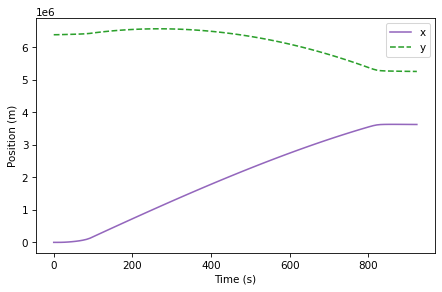

In [18]:
results.x.plot(color='C4')
results.y.plot(color='C2', style='--')

print(results.x.max())
print(results.y.max())
print(results.x.min())
print(results.y.min())

decorate(xlabel='Time (s)',
         ylabel='Position (m)')

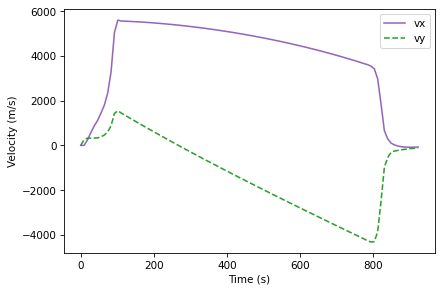

In [19]:
results.vx.plot(color='C4')
results.vy.plot(color='C2', style='--')

decorate(xlabel='Time (s)',
         ylabel='Velocity (m/s)')

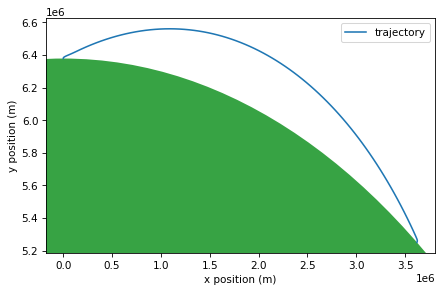

In [20]:
def plot_trajectory(results):
    x = results.x
    y = results.y
    make_series(x, y).plot(label='trajectory')

    decorate(xlabel='x position (m)',
             ylabel='y position (m)')
    
    ax = plt.gca()
    pp2 = plt.Circle((0, 0), params.earth_diameter / 2)
    pp2.set_facecolor('#37a344')
    ax.add_patch(pp2)
    
    

plot_trajectory(results)

In [21]:
more_results = {
    'ax': pd.Series(), 
    'ay': pd.Series(), 
    'gx': pd.Series(), 
    'gy': pd.Series(), 
    'atx': pd.Series(), 
    'aty': pd.Series(), 
    'ftx': pd.Series(), 
    'fty': pd.Series(), 
    'mass': pd.Series()
    }

for t in results.x.index:
    calculations = calculate_all(t, results.x[t], results.y[t], results.vx[t], results.vy[t])
    more_results['ax'][t] = calculations.acceleration.total.x
    more_results['ay'][t] = calculations.acceleration.total.y
    more_results['gx'][t] = calculations.acceleration.gravity.x
    more_results['gy'][t] = calculations.acceleration.gravity.y
    more_results['atx'][t] = calculations.acceleration.trust.x
    more_results['aty'][t] = calculations.acceleration.trust.y
    more_results['atx'][t] = calculations.forces.trust.x
    more_results['aty'][t] = calculations.forces.trust.y
    more_results['mass'][t] = calculations.mass

more_df = pd.DataFrame(data=more_results)

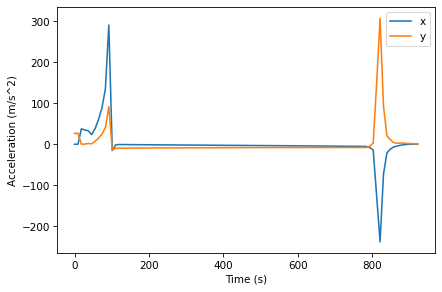

In [22]:
more_df.ax.plot(label='x')
more_df.ay.plot(label='y')

decorate(xlabel='Time (s)',
            ylabel='Acceleration (m/s^2)')

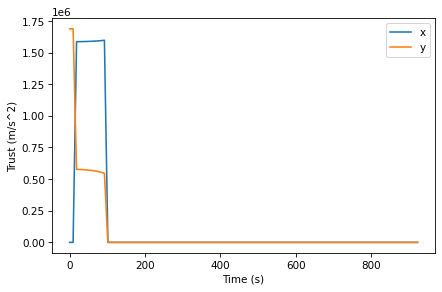

In [23]:
more_df.atx.plot(label='x')
more_df.aty.plot(label='y')

decorate(xlabel='Time (s)',
            ylabel='Trust (m/s^2)')

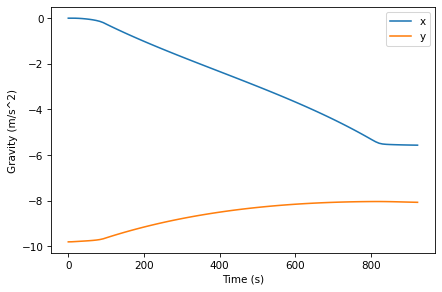

In [24]:
more_df.gx.plot(label='x')
more_df.gy.plot(label='y')

decorate(xlabel='Time (s)',
            ylabel='Gravity (m/s^2)')

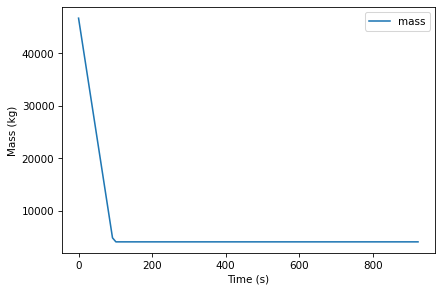

In [25]:
more_df.mass.plot(label='mass')

decorate(xlabel='Time (s)',
            ylabel='Mass (kg)')

In [26]:
from matplotlib.pyplot import plot

xlim = results.x.min(), results.x.max()
ylim = results.y.min(), results.y.max()

def draw_func(t, state):
    plot(state.x, state.y, 'bo')
    decorate(xlabel='x position (m)',
             ylabel='y position (m)',
             xlim=xlim,
             ylim=ylim)

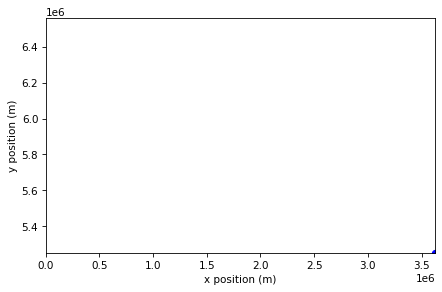

In [27]:
animate(results, draw_func)